# Spark를 통해 ELT 후 시각화
E: extract
L: load
T: transform

In [33]:
import pandas as pd
# 한글깨짐 방지
#!apt -qq -y install fonts-nanum > /dev/null
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

In [1]:
import findspark

findspark.init()

In [2]:
import pymysql

In [3]:
import pandas as pd
import pymongo
from pymongo import MongoClient

In [4]:
import pyspark.pandas as ps

In [5]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local").appName("spark-dataframe").getOrCreate()

In [6]:
# from pyspark import SparkConf, SparkContext
# conf = SparkConf().setMaster("local").setAppName("spark_sql_basic")
# sc = SparkContext(conf=conf)

In [7]:
# 데이터가 매우 큰 경우 강제로 사용할 메모리의 용량을 설정(기준 2기가)
MAX_MEMORY = "5g" # 인스턴스에 여러명이 붙어 있어서 안될 수 있지만 단일 인스턴스 때 사용가능.

spark = SparkSession.builder.appName("movie-recommendation")\
     .config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory",MAX_MEMORY).getOrCreate()
# 메모리 오류나면 이줄과 아래줄 주석처리진행.

In [120]:
file='C:/Users/psk/3rd_pj/kream_product2.csv'
file1='C:/Users/psk/3rd_backup/kream_price.csv'
file2='C:/Users/psk/3rd_backup/mysql_conn/Spark/series_benefit.csv'

In [140]:
id1 = spark.read.csv(f"file:///{file}",inferSchema=True, header=True)
id1.show(1)


+--------------------+--------+-------------------------+-------------+----------+------------+------------------+-------------+-----------------+------------------+--------------------+---+-----+---+---+---+---+-------+----+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----+----+----+----+----+----+----+----+--------+------+----+----+----+----+--------+----+----+----+--------+----+------+----+----+----+------+----+----+----+------------+------------+-----+--------+--------------------+---------+--------+-----------+----+-----------------+-----------------+-------------+----+-------+-------------------+----------+-----------------+--------------+-----+-------+-----+--------------+-------------+-------------+--------+---+-------------+------------+----+---+--------+-----+------------+----------+----+-------------+---

In [122]:
price1 = spark.read.csv(f"file:///{file1}",inferSchema=True, header=True)
price1.show(3)

+--------------------+----------+----------+---------+---------+
|                 _id|  model_no|last_price|max_price|min_price|
+--------------------+----------+----------+---------+---------+
|Jordan 1 Low Vint...|553558-053|    228000|   228000|   206000|
|Jordan 1 x Travis...|DM7866-140|   1789000|  4000000|  1146000|
|Jordan 1 Retro Hi...|555088-105|    825000|   897000|   304000|
+--------------------+----------+----------+---------+---------+
only showing top 3 rows



In [123]:
benefit = spark.read.csv(f"file:///{file2}",inferSchema=True, header=True)
benefit.show(3)

+--------------------+-------------+-------------+---+-----+---+---+---+---+----------+----------+---------+---------+------------------+
|                 _id|rescent_price|release_price| OG|Retro| SP| QS| SB| SE|  model_no|last_price|max_price|min_price|           benefit|
+--------------------+-------------+-------------+---+-----+---+---+---+---+----------+----------+---------+---------+------------------+
|Jordan 1 Low Vint...|       200000|       129000|  0|    0|  0|  0|  0|  0|553558-053|  228000.0| 228000.0| 206000.0|176.74418604651163|
|Jordan 1 x Travis...|      1555000|       189000|  1|    1|  1|  0|  0|  0|DM7866-140| 1789000.0|4000000.0|1146000.0| 946.5608465608465|
|Jordan 1 Retro Hi...|       702000|       199000|  1|    1|  0|  0|  0|  0|555088-105|  825000.0| 897000.0| 304000.0|414.57286432160805|
+--------------------+-------------+-------------+---+-----+---+---+---+---+----------+----------+---------+---------+------------------+
only showing top 3 rows



In [124]:
id1.createOrReplaceTempView("id")
price1.createOrReplaceTempView("price")
benefit.createOrReplaceTempView("benefit")

In [125]:
query='''select _id,rescent_price,release_price,OG,Retro,SP
from id
'''
spark.sql(query).show()

+--------------------+-------------+-------------+---+-----+---+
|                 _id|rescent_price|release_price| OG|Retro| SP|
+--------------------+-------------+-------------+---+-----+---+
|Jordan 1 Low Vint...|       200000|       129000|  0|    0|  0|
|Jordan 1 x Travis...|      1555000|       189000|  1|    1|  1|
|Jordan 1 Retro Hi...|       702000|       199000|  1|    1|  0|
|Jordan 4 Retro Wh...|       312000|       249000|  0|    1|  0|
|Jordan 1 Retro Hi...|       244000|       209000|  1|    1|  0|
|Jordan 1 Low Golf...|       336000|       179000|  0|    0|  0|
|Jordan 1 Mid Ligh...|       215000|       149000|  0|    0|  0|
|(W) Jordan 1 Elev...|       265000|       159000|  0|    0|  0|
|Jordan 1 Retro Hi...|       387000|       199000|  1|    1|  0|
|Jordan 1 Low OG S...|       372000|       159000|  1|    0|  0|
|Jordan 1 Low Golf...|       352000|       179000|  0|    0|  0|
|(W) Jordan 1 Low ...|       201000|       129000|  0|    0|  0|
|(W) Jordan 1 Low ...|   

In [126]:
# _id 와 price 조인
query='''
select A._id,A.OG,A.Retro,A.SP,B.model_no,B.last_price
from(select _id,rescent_price,release_price,OG,Retro,SP
from id) A
left join price B
on A._id=B._id
'''
t1 = spark.sql(query)
t1.show()

+--------------------+---+-----+---+----------+----------+
|                 _id| OG|Retro| SP|  model_no|last_price|
+--------------------+---+-----+---+----------+----------+
|Jordan 1 Low Vint...|  0|    0|  0|553558-053|    228000|
|Jordan 1 x Travis...|  1|    1|  1|DM7866-140|   1789000|
|Jordan 1 Retro Hi...|  1|    1|  0|555088-105|    825000|
|Jordan 4 Retro Wh...|  0|    1|  0|DH6927-111|    309000|
|Jordan 1 Retro Hi...|  1|    1|  0|555088-108|    294000|
|Jordan 1 Low Golf...|  0|    0|  0|DD9315-002|    395000|
|Jordan 1 Mid Ligh...|  0|    0|  0|554724-078|    210000|
|(W) Jordan 1 Elev...|  0|    0|  0|DH7004-100|    260000|
|Jordan 1 Retro Hi...|  1|    1|  0|555088-134|    780000|
|Jordan 1 Low OG S...|  1|    0|  0|CZ0790-801|    385000|
|Jordan 1 Low Golf...|  0|    0|  0|DD9315-600|    450000|
|(W) Jordan 1 Low ...|  0|    0|  0|DC0774-041|    259000|
|(W) Jordan 1 Low ...|  0|    0|  0|DC0774-105|    356000|
|(W) Jordan 1 Low ...|  0|    0|  0|DC0774-114|    19200

In [127]:
t1.filter("OG=='1'").count()

222

In [128]:
# series별 갯수세기
# join 할 필요 없는데 연습겸
query='''
select sum(case when K._id like '%OG%' then 1 else 0 end) OG_count,
	   sum(case when K._id like '%Retro%' then 1 else 0 end) Retro_count,
       sum(case when K._id like '%SP%' then 1 else 0 end) SP_count
from(select A._id,A.OG,A.Retro,A.SP,B.model_no,B.last_price
from(select _id,rescent_price,release_price,OG,Retro,SP
from id) A
left join price B
on A._id=B._id) K
'''
spark.sql(query).show()


+--------+-----------+--------+
|OG_count|Retro_count|SP_count|
+--------+-----------+--------+
|     222|       1600|      71|
+--------+-----------+--------+



In [129]:
# series별 수익률을 알아보기
# id와 benefit table 조인
query='''
select *
from(select A._id,A.OG,A.Retro,A.SP,B.model_no,B.benefit
from(select _id,rescent_price,release_price,OG,Retro,SP
from id) A
left join benefit B
on A._id=B._id) K
'''
t2 = spark.sql(query)
t2.show(5)

+--------------------+---+-----+---+----------+------------------+
|                 _id| OG|Retro| SP|  model_no|           benefit|
+--------------------+---+-----+---+----------+------------------+
|Jordan 1 Low Vint...|  0|    0|  0|553558-053|176.74418604651163|
|Jordan 1 x Travis...|  1|    1|  1|DM7866-140| 946.5608465608465|
|Jordan 1 Retro Hi...|  1|    1|  0|555088-105|414.57286432160805|
|Jordan 4 Retro Wh...|  0|    1|  0|DH6927-111|124.09638554216869|
|Jordan 1 Retro Hi...|  1|    1|  0|555088-108|140.66985645933013|
+--------------------+---+-----+---+----------+------------------+
only showing top 5 rows



In [130]:
# OG 시리즈 평균 수익률 확인
query='''
select avg(benefit)
from(select A._id,A.OG,A.Retro,A.SP,B.model_no,B.benefit
from(select _id,rescent_price,release_price,OG,Retro,SP
from id) A
left join benefit B
on A._id=B._id) K
group by OG
having OG='1'
'''
spark.sql(query).show()


+------------------+
|      avg(benefit)|
+------------------+
|277.82017824670066|
+------------------+



In [132]:
t1.groupby('OG').mean('last_price').show()

+---+-----------------+
| OG|  avg(last_price)|
+---+-----------------+
|  1|695176.4705882353|
|  0|311603.0341340076|
+---+-----------------+



In [133]:
t1.groupby('Retro').mean('last_price').show()

+-----+-----------------+
|Retro|  avg(last_price)|
+-----+-----------------+
|    1|439956.3318777293|
|    0|282530.9734513274|
+-----+-----------------+



In [134]:
t1.groupby('SP').mean('last_price').show()

+---+-----------------+
| SP|  avg(last_price)|
+---+-----------------+
|  1|648763.1578947369|
|  0|349255.7339449541|
+---+-----------------+



In [135]:
sample_1 = [('Retro','458'),('SP','38'),('OG','119'),('Others','290')]
sample_1

[('Retro', '458'), ('SP', '38'), ('OG', '119'), ('Others', '290')]

In [136]:
sample_2={'series':['Retro','SP','OG'],
          'count':[1600,71,222]}

In [137]:
tmp2 = pd.DataFrame(sample_2)
series_sdf=spark.createDataFrame(tmp2)
series_sdf.show()

+------+-----+
|series|count|
+------+-----+
| Retro| 1600|
|    SP|   71|
|    OG|  222|
+------+-----+



In [138]:
sample_3={'series':['Retro','SP','OG'],
          'benefit':[203,290,277]}

In [112]:
tmp3 = pd.DataFrame(sample_3)
series_3=spark.createDataFrame(tmp3)
series_3.show()

+------+-------+
|series|benefit|
+------+-------+
| Retro|    203|
|    SP|    290|
|    OG|    277|
+------+-------+



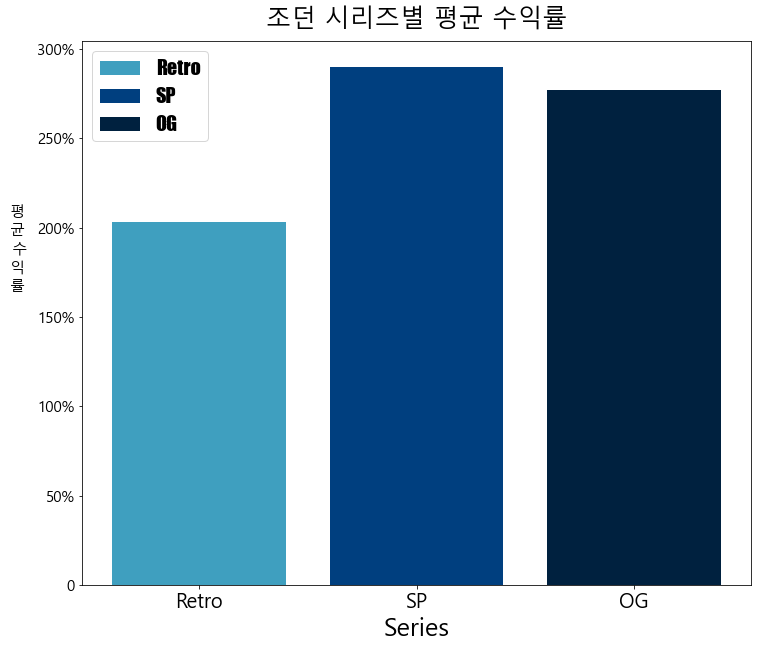

In [118]:
series=['Retro','OG','SP']


colors = sns.color_palette('ocean_r',len(tmp3))

fig = plt.figure(figsize=(12,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 프레임(그림 뼈대) 생성

# sns.barplot(x='series', y='count', data=tmp2, color=colors)

bars = ax.bar(tmp3['series'],tmp3['benefit'],color=colors)

prop = dict(
    family='fantasy', # 글씨체
    style='italic', # 글씨 형식 - 이탤릭형식
    size=20) # 글씨 크기
ax.legend(handles=bars,labels=list(tmp3['series']),prop=prop)

plt.xlabel("Series",fontsize=25)
plt.ylabel("평\n균\n 수\n익\n률\n",fontsize=15,rotation=0,labelpad=20)
plt.title("조던 시리즈별 평균 수익률",loc="center",fontsize=25,pad=15)
# ax = plt.gca()
# ax.set_facecolor('#FAF5EF')
plt.xticks(rotation=0,fontsize=20)
plt.yticks([0,50,100,150,200,250,300],['0','50%','100%','150%','200%','250%','300%'],fontsize=15)
# ax = plt.gca()
# ax.set_facecolor('#FAF5EF')
plt.savefig('조던 시리즈별 평균 수익률.png')
plt.show()


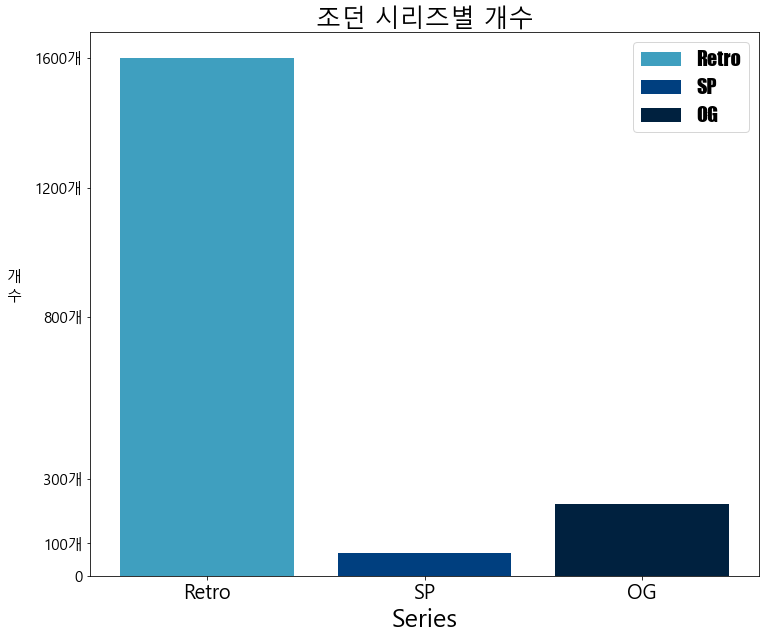

In [119]:
series=['Retro','OG','SP']


colors = sns.color_palette('ocean_r',len(tmp2))

fig = plt.figure(figsize=(12,10)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 프레임(그림 뼈대) 생성

# sns.barplot(x='series', y='count', data=tmp2, color=colors)

bars = ax.bar(tmp2['series'],tmp2['count'],color=colors)

prop = dict(
    family='fantasy', # 글씨체
    style='italic', # 글씨 형식 - 이탤릭형식
    size=20) # 글씨 크기
ax.legend(handles=bars,labels=list(tmp2['series']),prop=prop)

plt.xlabel("Series",fontsize=25)
plt.ylabel("개\n수",fontsize=15,rotation=0,labelpad=20)
plt.title("조던 시리즈별 개수",loc="center",fontsize=25,pad=5)
# ax = plt.gca()
# ax.set_facecolor('#FAF5EF')
plt.xticks(rotation=0,fontsize=20)
plt.yticks([0,100,300,800,1200,1600],['0','100개','300개','800개','1200개','1600개'],fontsize=15)
# ax = plt.gca()
# ax.set_facecolor('#FAF5EF')
plt.savefig('total_count.png')
plt.show()
